# Federico Ariton
# Master of Science in Data Analytics
# Semester 2 - CA2 Integreated
# Student Number: sba22090

In [3]:
from pymongo import MongoClient
import pandas as pd

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["stock_data"]
collection = db["sentiment"]

# Load documents
documents = list(collection.find())
df = pd.DataFrame(documents).drop(columns=['_id'], errors='ignore')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['ticker', 'date']).reset_index(drop=True)


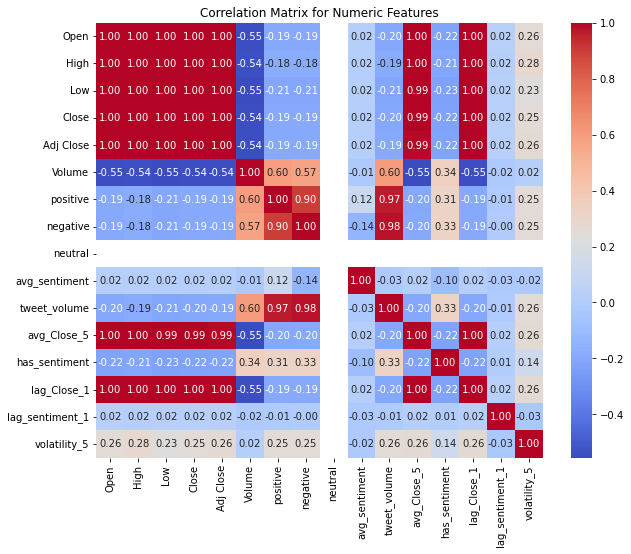

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert categorical
numeric_df = df.select_dtypes(include='number').dropna()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()

In [5]:
required_cols = ['lag_Close_1', 'lag_sentiment_1', 'avg_Close_5', 'volatility_5',
                 'avg_sentiment', 'tweet_volume', 'Close']  # Target is 'Close'

## Training Model with optimizers

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from pandas.tseries.offsets import BDay
import warnings
warnings.filterwarnings('ignore')

# Optimizer selector
def get_optimizer(name, lr=0.001):
    if name == "RMSprop": return RMSprop(learning_rate=lr)
    if name == "Adam": return Adam(learning_rate=lr)
    if name == "NAG": return SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    raise ValueError("Unsupported optimizer")

# RNN model builder
def build_model(model_type, input_shape, optimizer):
    model = Sequential()
    RNN = LSTM if model_type == 'LSTM' else GRU
    model.add(RNN(64, return_sequences=True, input_shape=input_shape))
    model.add(RNN(32))
    model.add(Dense(7))  # 7-day forecast
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Create sequences for time series
def create_sequences(data, features, target_col, window_size=20, horizon=7):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size][features].values)
        y.append(data[i+window_size:i+window_size+horizon][target_col].values)
    return np.array(X), np.array(y)


2025-05-14 18:13:59.480314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747242839.491962  138778 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747242839.495426  138778 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747242839.504935  138778 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747242839.504955  138778 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747242839.504956  138778 computation_placer.cc:177] computation placer alr

In [7]:
tickers = ['AAPL', 'AMZN', 'BA', 'DIS', 'MSFT', 'TSLA']
forecast_records = []

for ticker in tickers:
    ticker_df = df[df['ticker'] == ticker].dropna(subset=required_cols)
    if len(ticker_df) < 30: continue 

    scaler = MinMaxScaler()
    ticker_df[required_cols] = scaler.fit_transform(ticker_df[required_cols])

    # Create sequences
    X, y = create_sequences(ticker_df, required_cols[:-1], 'Close', window_size=20, horizon=7)
    if len(X) < 2: continue

    X_train, X_test = X[:-1], X[-1:]
    y_train, y_test = y[:-1], y[-1:]
    run_date = ticker_df['date'].iloc[-1]

    for model_type in ['LSTM', 'GRU']:
        optimizer_name = {
            'LSTM': {'AAPL': 'RMSprop', 'AMZN': 'RMSprop', 'BA': 'NAG', 'DIS': 'RMSprop', 'MSFT': 'Adam', 'TSLA': 'Adam'},
            'GRU': {'AAPL': 'RMSprop', 'AMZN': 'Adam', 'BA': 'RMSprop', 'DIS': 'RMSprop', 'MSFT': 'Adam', 'TSLA': 'RMSprop'}
        }[model_type][ticker]

        optimizer = get_optimizer(optimizer_name)
        model = build_model(model_type, (X_train.shape[1], X_train.shape[2]), optimizer)
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Evaluation forecast
        y_pred = model.predict(X_test)[0]
        y_true = y_test[0]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        for i in range(7):
            forecast_records.append({
                "forecast_date": run_date + BDay(i + 1),
                "stock": ticker,
                "model": f"{model_type}+{optimizer_name}",
                "forecast_horizon": i + 1,
                "forecasted_close": y_pred[i],
                "actual_close": y_true[i],
                "rmse": rmse,
                "run_date": run_date
            })

        # Future forecast
        last_window = ticker_df[required_cols[:-1]].iloc[-20:].values
        future_input = np.expand_dims(last_window, axis=0)
        future_pred = model.predict(future_input)[0]

        for i in range(7):
            forecast_records.append({
                "forecast_date": run_date + BDay(i + 1),
                "stock": ticker,
                "model": f"{model_type}+{optimizer_name}",
                "forecast_horizon": i + 1,
                "forecasted_close": future_pred[i],
                "actual_close": None,
                "rmse": None,
                "run_date": run_date
            })


2025-05-14 18:14:06.407192: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [8]:
forecast_df = pd.DataFrame(forecast_records)

In [9]:
forecast_df.head(50)

forecast_date stock         model  forecast_horizon  forecasted_close  \
0     2021-01-01  AAPL  LSTM+RMSprop                 1          0.912310   
1     2021-01-04  AAPL  LSTM+RMSprop                 2          0.867714   
2     2021-01-05  AAPL  LSTM+RMSprop                 3          0.881164   
3     2021-01-06  AAPL  LSTM+RMSprop                 4          0.877479   
4     2021-01-07  AAPL  LSTM+RMSprop                 5          0.856923   
5     2021-01-08  AAPL  LSTM+RMSprop                 6          0.838847   
6     2021-01-11  AAPL  LSTM+RMSprop                 7          0.843535   
7     2021-01-01  AAPL  LSTM+RMSprop                 1          0.930429   
8     2021-01-04  AAPL  LSTM+RMSprop                 2          0.879900   
9     2021-01-05  AAPL  LSTM+RMSprop                 3          0.906152   
10    2021-01-06  AAPL  LSTM+RMSprop                 4          0.889803   
11    2021-01-07  AAPL  LSTM+RMSprop                 5          0.880041   
12    2021-01-08  AAPL  LSTM+RMSprop                 6          0.866845   
13    2021-01-11  AAPL  LSTM+RMSprop                 7          0.855960   
14    2021-01-01  AAPL   GRU+RMSprop                 1          0.790719   
15    2021-01-04  AAPL   GRU+RMSprop                 2          0.762583   
16    2021-01-05  AAPL   GRU+RMSprop                 3          0.816582   
17    2021-01-06  AAPL   GRU+RMSprop                 4          0.756432   
18    2021-01-07  AAPL   GRU+RMSprop                 5          0.798607   
19    2021-01-08  AAPL   GRU+RMSprop                 6          0.777840   
20    2021-01-11  AAPL   GRU+RMSprop                 7          0.801169   
21    2021-01-01  AAPL   GRU+RMSprop                 1          0.860693   
22    2021-01-04  AAPL   GRU+RMSprop                 2          0.841726   
23    2021-01-05  AAPL   GRU+RMSprop                 3          0.872140   
24    2021-01-06  AAPL   GRU+RMSprop                 4          0.835987   
25    2021-01-07  AAPL   GRU+RMSprop                 5          0.849196   
26    2021-01-08  AAPL   GRU+RMSprop                 6          0.856042   
27    2021-01-11  AAPL   GRU+RMSprop                 7          0.890132   
28    2021-01-01  AMZN  LSTM+RMSprop                 1          0.793225   
29    2021-01-04  AMZN  LSTM+RMSprop                 2          0.828390   
30    2021-01-05  AMZN  LSTM+RMSprop                 3          0.828926   
31    2021-01-06  AMZN  LSTM+RMSprop                 4          0.809997   
32    2021-01-07  AMZN  LSTM+RMSprop                 5          0.805797   
33    2021-01-08  AMZN  LSTM+RMSprop                 6          0.808210   
34    2021-01-11  AMZN  LSTM+RMSprop                 7          0.809986   
35    2021-01-01  AMZN  LSTM+RMSprop                 1          0.807037   
36    2021-01-04  AMZN  LSTM+RMSprop                 2          0.841990   
37    2021-01-05  AMZN  LSTM+RMSprop                 3          0.833898   
38    2021-01-06  AMZN  LSTM+RMSprop                 4          0.822280   
39    2021-01-07  AMZN  LSTM+RMSprop                 5          0.806504   
40    2021-01-08  AMZN  LSTM+RMSprop                 6          0.820679   
41    2021-01-11  AMZN  LSTM+RMSprop                 7          0.812729   
42    2021-01-01  AMZN      GRU+Adam                 1          0.836604   
43    2021-01-04  AMZN      GRU+Adam                 2          0.827492   
44    2021-01-05  AMZN      GRU+Adam                 3          0.837839   
45    2021-01-06  AMZN      GRU+Adam                 4          0.844423   
46    2021-01-07  AMZN      GRU+Adam                 5          0.830609   
47    2021-01-08  AMZN      GRU+Adam                 6          0.852219   
48    2021-01-11  AMZN      GRU+Adam                 7          0.851935   
49    2021-01-01  AMZN      GRU+Adam                 1          0.872725   

    actual_close      rmse   run_date  
0       0.940321  0.096034 2020-12-31  
1       0.928906  0.096034 2020-12-31  
2     

# Hyperparameters

In [10]:
from itertools import product

# Define hyperparameter grid
hyperparams_grid = {
    'epochs': [50, 100],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0005],
    'window_size': [10, 20]
}

forecast_records = []

for ticker in tickers:
    base_df = df[df['ticker'] == ticker].dropna(subset=required_cols).copy()
    if len(base_df) < 30:
        continue

    run_date = base_df['date'].iloc[-1]

    for model_type in ['LSTM', 'GRU']:
        optimizer_name = {
            'LSTM': {'AAPL': 'RMSprop', 'AMZN': 'RMSprop', 'BA': 'NAG', 'DIS': 'RMSprop', 'MSFT': 'Adam', 'TSLA': 'Adam'},
            'GRU': {'AAPL': 'RMSprop', 'AMZN': 'Adam', 'BA': 'RMSprop', 'DIS': 'RMSprop', 'MSFT': 'Adam', 'TSLA': 'RMSprop'}
        }[model_type][ticker]

        for epochs, batch_size, lr, window_size in product(
            hyperparams_grid['epochs'],
            hyperparams_grid['batch_size'],
            hyperparams_grid['learning_rate'],
            hyperparams_grid['window_size']
        ):
            try:
                ticker_df = base_df.copy()
                scaler = MinMaxScaler()
                ticker_df[required_cols] = scaler.fit_transform(ticker_df[required_cols])

                X, y = create_sequences(ticker_df, required_cols[:-1], 'Close', window_size=window_size, horizon=7)
                if len(X) < 2:
                    continue

                X_train, X_test = X[:-1], X[-1:]
                y_train, y_test = y[:-1], y[-1:]

                optimizer = get_optimizer(optimizer_name, lr=lr)
                model = build_model(model_type, (X_train.shape[1], X_train.shape[2]), optimizer)
                model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                y_pred = model.predict(X_test)[0]
                y_true = y_test[0]
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))

                for i in range(7):
                    forecast_records.append({
                        "forecast_date": run_date + BDay(i + 1),
                        "stock": ticker,
                        "model": f"{model_type}+{optimizer_name}",
                        "forecast_horizon": i + 1,
                        "forecasted_close": y_pred[i],
                        "actual_close": y_true[i],
                        "rmse": rmse,
                        "run_date": run_date,
                        "epochs": epochs,
                        "batch_size": batch_size,
                        "learning_rate": lr,
                        "window_size": window_size
                    })

                # Future forecast
                last_window = ticker_df[required_cols[:-1]].iloc[-window_size:].values
                future_input = np.expand_dims(last_window, axis=0)
                future_pred = model.predict(future_input)[0]

                for i in range(7):
                    forecast_records.append({
                        "forecast_date": run_date + BDay(i + 1),
                        "stock": ticker,
                        "model": f"{model_type}+{optimizer_name}",
                        "forecast_horizon": i + 1,
                        "forecasted_close": future_pred[i],
                        "actual_close": None,
                        "rmse": None,
                        "run_date": run_date,
                        "epochs": epochs,
                        "batch_size": batch_size,
                        "learning_rate": lr,
                        "window_size": window_size
                    })

            except Exception as e:
                print(f"[ERROR] {ticker}-{model_type} {epochs}/{batch_size}/{lr}/{window_size}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

In [11]:
results_df = pd.DataFrame(forecast_records)

In [12]:
results_df

forecast_date stock         model  forecast_horizon  forecasted_close  \
0       2021-01-01  AAPL  LSTM+RMSprop                 1          0.852654   
1       2021-01-04  AAPL  LSTM+RMSprop                 2          0.861585   
2       2021-01-05  AAPL  LSTM+RMSprop                 3          0.851694   
3       2021-01-06  AAPL  LSTM+RMSprop                 4          0.831434   
4       2021-01-07  AAPL  LSTM+RMSprop                 5          0.867894   
...            ...   ...           ...               ...               ...   
2683    2021-01-05  TSLA   GRU+RMSprop                 3          0.909123   
2684    2021-01-06  TSLA   GRU+RMSprop                 4          0.952339   
2685    2021-01-07  TSLA   GRU+RMSprop                 5          0.955701   
2686    2021-01-08  TSLA   GRU+RMSprop                 6          0.956739   
2687    2021-01-11  TSLA   GRU+RMSprop                 7          0.988253   

      actual_close      rmse   run_date  epochs  batch_size  learning_rate  \
0         0.940321  0.100083 2020-12-31      50          16         0.0010   
1         0.928906  0.100083 2020-12-31      50          16         0.0010   
2         0.941437  0.100083 2020-12-31      50          16         0.0010   
3         1.000000  0.100083 2020-12-31      50          16         0.0010   
4         0.977419  0.100083 2020-12-31      50          16         0.0010   
...            ...       ...        ...     ...         ...            ...   
2683           NaN       NaN 2020-12-31     100          32         0.0005   
2684           NaN       NaN 2020-12-31     100          32         0.0005   
2685           NaN       NaN 2020-12-31     100          32         0.0005   
2686           NaN       NaN 2020-12-31     100          32         0.0005   
2687           NaN       NaN 2020-12-31     100          32         0.0005   

      window_size  
0              10  
1              10  
2              10  
3              10  
4              10  
...           ...  
2683           20  
2684           20  
2685           20  
2686           20  
2687           20  

[2688 rows x 12 columns]

## Extract best result with less loss function

In [13]:
eval_7 = results_df[
    (results_df['forecast_horizon'] == 7) &
    (results_df['actual_close'].notna())
]

In [14]:
best_configs = (
    eval_7.sort_values('rmse')
    .groupby(['stock', 'model'])
    .first()
    .reset_index()
)

In [15]:
best_forecasts_all_horizons = results_df.merge(
    best_configs[['stock', 'model', 'epochs', 'batch_size', 'learning_rate', 'window_size']],
    on=['stock', 'model', 'epochs', 'batch_size', 'learning_rate', 'window_size'],
    how='inner'
).sort_values(['stock', 'model', 'forecast_date', 'forecast_horizon'])

In [16]:
best_forecasts_all_horizons.head(50)

forecast_date stock         model  forecast_horizon  forecasted_close  \
14    2021-01-01  AAPL   GRU+RMSprop                 1          0.950956   
21    2021-01-01  AAPL   GRU+RMSprop                 1          1.027555   
15    2021-01-04  AAPL   GRU+RMSprop                 2          0.943811   
22    2021-01-04  AAPL   GRU+RMSprop                 2          1.026398   
16    2021-01-05  AAPL   GRU+RMSprop                 3          0.967331   
23    2021-01-05  AAPL   GRU+RMSprop                 3          1.064680   
17    2021-01-06  AAPL   GRU+RMSprop                 4          0.964605   
24    2021-01-06  AAPL   GRU+RMSprop                 4          1.051329   
18    2021-01-07  AAPL   GRU+RMSprop                 5          0.977610   
25    2021-01-07  AAPL   GRU+RMSprop                 5          1.073092   
19    2021-01-08  AAPL   GRU+RMSprop                 6          0.940310   
26    2021-01-08  AAPL   GRU+RMSprop                 6          1.047149   
20    2021-01-11  AAPL   GRU+RMSprop                 7          0.937974   
27    2021-01-11  AAPL   GRU+RMSprop                 7          1.032023   
0     2021-01-01  AAPL  LSTM+RMSprop                 1          0.928419   
7     2021-01-01  AAPL  LSTM+RMSprop                 1          0.961263   
1     2021-01-04  AAPL  LSTM+RMSprop                 2          0.944081   
8     2021-01-04  AAPL  LSTM+RMSprop                 2          0.975965   
2     2021-01-05  AAPL  LSTM+RMSprop                 3          0.954099   
9     2021-01-05  AAPL  LSTM+RMSprop                 3          0.991189   
3     2021-01-06  AAPL  LSTM+RMSprop                 4          0.960570   
10    2021-01-06  AAPL  LSTM+RMSprop                 4          0.993587   
4     2021-01-07  AAPL  LSTM+RMSprop                 5          0.966422   
11    2021-01-07  AAPL  LSTM+RMSprop                 5          1.010672   
5     2021-01-08  AAPL  LSTM+RMSprop                 6          0.944401   
12    2021-01-08  AAPL  LSTM+RMSprop                 6          0.979699   
6     2021-01-11  AAPL  LSTM+RMSprop                 7          0.952136   
13    2021-01-11  AAPL  LSTM+RMSprop                 7          0.986174   
42    2021-01-01  AMZN      GRU+Adam                 1          0.823705   
49    2021-01-01  AMZN      GRU+Adam                 1          0.833884   
43    2021-01-04  AMZN      GRU+Adam                 2          0.851717   
50    2021-01-04  AMZN      GRU+Adam                 2          0.851807   
44    2021-01-05  AMZN      GRU+Adam                 3          0.844086   
51    2021-01-05  AMZN      GRU+Adam                 3          0.860112   
45    2021-01-06  AMZN      GRU+Adam                 4          0.849231   
52    2021-01-06  AMZN      GRU+Adam                 4          0.862526   
46    2021-01-07  AMZN      GRU+Adam                 5          0.855459   
53    2021-01-07  AMZN      GRU+Adam                 5          0.877140   
47    2021-01-08  AMZN      GRU+Adam                 6          0.855970   
54    2021-01-08  AMZN      GRU+Adam                 6          0.871250   
48    2021-01-11  AMZN      GRU+Adam                 7          0.858905   
55    2021-01-11  AMZN      GRU+Adam                 7          0.850874   
28    2021-01-01  AMZN  LSTM+RMSprop                 1          0.817420   
35    2021-01-01  AMZN  LSTM+RMSprop                 1          0.827447   
29    2021-01-04  AMZN  LSTM+RMSprop                 2          0.836817   
36    2021-01-04  AMZN  LSTM+RMSprop                 2          0.840893   
30    2021-01-05  AMZN  LSTM+RMSprop                 3          0.855986   
37    2021-01-05  AMZN  LSTM+RMSprop                 3          0.856398   
31    2021-01-06  AMZN  LSTM+RMSprop                 4          0.841558   
38    2021-01-06  AMZN  LSTM+RMSprop                 4          0.846371   

    actual_close      rmse   run_date  epochs  batch_size  learning_rate  \
14      0.940321  0.020473 2020-12-31      50     

In [17]:
# Reset the index
best_forecasts_all_horizons = best_forecasts_all_horizons.reset_index(drop=True)

# Drop tuning parameters
best_forecasts_all_horizons = best_forecasts_all_horizons.drop(columns=[
    'epochs', 'batch_size', 'learning_rate', 'window_size'
])


In [18]:
best_forecasts_all_horizons

forecast_date stock        model  forecast_horizon  forecasted_close  \
0      2021-01-01  AAPL  GRU+RMSprop                 1          0.950956   
1      2021-01-01  AAPL  GRU+RMSprop                 1          1.027555   
2      2021-01-04  AAPL  GRU+RMSprop                 2          0.943811   
3      2021-01-04  AAPL  GRU+RMSprop                 2          1.026398   
4      2021-01-05  AAPL  GRU+RMSprop                 3          0.967331   
..            ...   ...          ...               ...               ...   
163    2021-01-07  TSLA    LSTM+Adam                 5          0.946299   
164    2021-01-08  TSLA    LSTM+Adam                 6          0.967147   
165    2021-01-08  TSLA    LSTM+Adam                 6          0.973211   
166    2021-01-11  TSLA    LSTM+Adam                 7          0.956867   
167    2021-01-11  TSLA    LSTM+Adam                 7          0.963227   

     actual_close      rmse   run_date  
0        0.940321  0.020473 2020-12-31  
1             NaN       NaN 2020-12-31  
2        0.928906  0.020473 2020-12-31  
3             NaN       NaN 2020-12-31  
4        0.941437  0.020473 2020-12-31  
..            ...       ...        ...  
163           NaN       NaN 2020-12-31  
164      0.982808  0.020539 2020-12-31  
165           NaN       NaN 2020-12-31  
166      1.000000  0.020539 2020-12-31  
167           NaN       NaN 2020-12-31  

[168 rows x 8 columns]

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Dictionary to store fitted scalers for each stock
scalers = {}

# Fit scaler per stock on original Close prices
for stock in best_forecasts_all_horizons['stock'].unique():
    stock_df = df[df['ticker'] == stock].copy()
    scaler = MinMaxScaler()
    scaler.fit(stock_df[['Close']].dropna())
    scalers[stock] = scaler

# Function to inverse-transform scaled values
def inverse_scaled_values(row):
    scaler = scalers[row['stock']]
    forecasted = scaler.inverse_transform([[row['forecasted_close']]])[0][0]
    actual = scaler.inverse_transform([[row['actual_close']]])[0][0] if pd.notna(row['actual_close']) else None
    return pd.Series([forecasted, actual], index=['forecasted_close', 'actual_close'])

# Apply inverse scaling
best_forecasts_all_horizons[['forecasted_close', 'actual_close']] = (
    best_forecasts_all_horizons.apply(inverse_scaled_values, axis=1)
)


In [20]:
best_forecasts_all_horizons.head()

forecast_date stock        model  forecast_horizon  forecasted_close  \
0    2021-01-01  AAPL  GRU+RMSprop                 1        132.737177   
1    2021-01-01  AAPL  GRU+RMSprop                 1        138.910847   
2    2021-01-04  AAPL  GRU+RMSprop                 2        132.161333   
3    2021-01-04  AAPL  GRU+RMSprop                 2        138.817592   
4    2021-01-05  AAPL  GRU+RMSprop                 3        134.056972   

   actual_close      rmse   run_date  
0    131.880005  0.020473 2020-12-31  
1           NaN       NaN 2020-12-31  
2    130.960007  0.020473 2020-12-31  
3           NaN       NaN 2020-12-31  
4    131.970001  0.020473 2020-12-31

# Save Back in the mongo DB

In [21]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["stock_data"]
collection = db["forecast_lstm_gru"]

# clean insert
collection.drop()

# Convert and save
collection.insert_many(best_forecasts_all_horizons.to_dict(orient='records'))

print("Cleaned forecast results saved to MongoDB!")


Cleaned forecast results saved to MongoDB!
